In [ ]:
#import necessary libraries
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder

In [27]:
# Importing the dataset
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [22]:
train_df.head()

,Unnamed: 0,surface_area,agricultural_land,forest_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,inflation_monthly,...,mobile_subscriptions,internet_users,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,internet_users_perc,mobile_subscriptions_num,agri_ratio,forest_ratio
0,0,120540.0,2.632839e+06,5.417843e+06,1379000.0,55.747169,4.688831,6.0,NaN,NaN,...,less than 1 per person,0 per 1000 people,NaN,1.0,[0%-25%),69.494195,0.000,0,0.218420,0.449464
1,1,752610.0,2.403039e+07,4.957554e+07,16500.0,16.890687,23.136313,0.0,NaN,0.581473,...,less than 1 per person,154 per 1000 people,2.623624e+06,3.0,[0%-25%),59.237366,0.154,0,0.319294,0.658715
2,2,1396.0,3.000000e+03,8.000000e+01,NaN,18.390090,23.139910,6.0,NaN,NaN,...,more than 1 per person,90 per 100 people,1.656589e+09,5.0,unknown,81.300000,0.900,1,0.021490,0.000573
3,3,2758812.0,1.228845e+08,1.050943e+08,1518650.0,50.966885,24.522427,3.0,1.374906,NaN,...,more than 1 per person,76 per 100 people,6.625072e+08,0.0,[25%-50%),81.373197,0.760,1,0.445426,0.380940
4,4,340.0,1.100000e+04,1.699000e+04,NaN,5.311885,30.271115,6.0,-0.044229,NaN,...,more than 1 per person,350 per 1000 people,2.832808e+07,0.0,[25%-50%),73.193561,0.350,1,0.323529,0.499706


In [9]:
train_df.dtypes

Unnamed: 0                         int64
surface_area                     float64
agricultural_land                float64
forest_area                      float64
armed_forces_total               float64
urban_pop_major_cities           float64
urban_pop_minor_cities           float64
national_income                   object
inflation_annual                 float64
inflation_monthly                float64
inflation_weekly                 float64
mobile_subscriptions              object
internet_users                    object
secure_internet_servers_total    float64
improved_sanitation               object
women_parliament_seats_rate       object
life_expectancy                  float64
dtype: object

In [55]:
train_df.improved_sanitation.value_counts()

improved_sanitation
very high access    155
low access           55
medium access        54
high access          47
very low access      33
no info              18
Name: count, dtype: int64

In [30]:
# Using OrdinalEncoder from sklearn to convert the categories in improved_sanitation to oridinal numbers
categories = ['very high access', 'high access', 'medium access', 'low access', 'very low access', 'no info']
ordinal_encoder = OrdinalEncoder(categories=[categories],unknown_value=None)
# Encoding the 'improved_sanitation' column in both train and test datasets
train_df["improved_sanitation"] = ordinal_encoder.fit_transform(train_df[["improved_sanitation"]])
test_df["improved_sanitation"] = ordinal_encoder.fit_transform(test_df[["improved_sanitation"]])

In [31]:
# Create a function to parse the cateogries in internet users into numeric format to use in ML model
def parse_internet_users(val):
    try:
        if isinstance(val, str) and "per" in val:
            parts = val.lower().split("per")
            num = parts[0].strip()
            denom = parts[1].strip().split(" ")[0]
            if num.isdigit() and denom.isdigit():
                return float(num) / float(denom)
            else:
                return None
    except:
        return None

In [32]:
train_df['internet_users_perc'] = train_df['internet_users'].apply(parse_internet_users)
test_df['internet_users_perc'] = test_df['internet_users'].apply(parse_internet_users)

In [33]:
# Create a function to parse the cateogries in mobile subscriptions into numeric format to use in ML model
def parse_mobile_subscriptions(val):
    if val == "more than 1 per person":
        return 1
    elif val == "less than 1 per person":
        return 0
    elif (val == "more than 2 per person" )or (val == "more than 3 per person"):
        return 2
    else:
        return 99
train_df["mobile_subscriptions_num"] = train_df.apply(lambda x: parse_mobile_subscriptions(x['mobile_subscriptions']), axis=1)
test_df["mobile_subscriptions_num"] = test_df.apply(lambda x: parse_mobile_subscriptions(x['mobile_subscriptions']), axis=1)

In [34]:
train_df.national_income.value_counts()
categories_income = ['very low','medium low','low','high','medium high','very high','unknown']
ordinal_encoder_income = OrdinalEncoder(categories=[categories_income], unknown_value=None)
# Encoding the 'national_income' column in both train and test datasets
train_df["national_income"] = ordinal_encoder_income.fit_transform(train_df[["national_income"]])
test_df["national_income"] = ordinal_encoder_income.fit_transform(test_df[["national_income"]])

<Axes: >

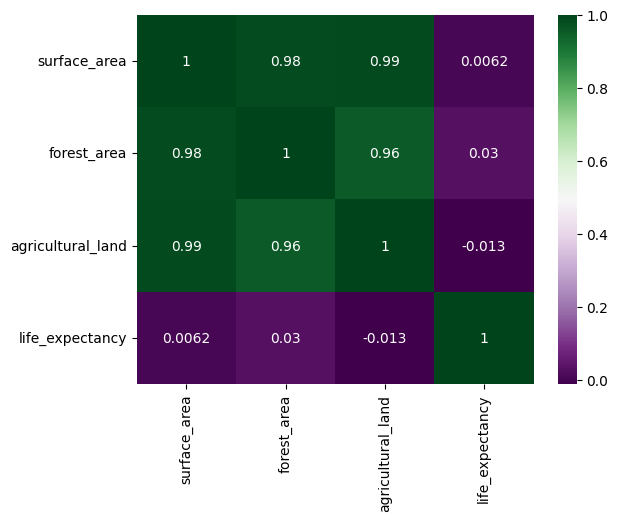

In [15]:
sns.heatmap(train_df[['surface_area','forest_area','agricultural_land','life_expectancy']].corr(),annot=True,cmap='PRGn')

In [19]:
# Value of surface area looks less that agri land and forest area, I was assuming that sum of these two would give surface area.
# Lets create 2 variables ratio of agri land/surface area and forest area/surface area assuming surface area is * 100 or 1000 to get a sense of meaningful ratio.
# The idea is to get what percent of land is agricultural vs forest from the total area available and use it as a feature
train_df["agri_ratio"] = train_df.agricultural_land/(train_df.surface_area*100)
train_df["forest_ratio"] = train_df.forest_area/(train_df.surface_area*100)
test_df["agri_ratio"] = test_df.agricultural_land/(test_df.surface_area*100)
test_df["forest_ratio"] = test_df.forest_area/(test_df.surface_area*100)


In [24]:
train_df[['Unnamed: 0', 'armed_forces_total', 'urban_pop_major_cities',
       'urban_pop_minor_cities', 'national_income', 'inflation_annual',
       'inflation_monthly', 'inflation_weekly', 'secure_internet_servers_total',
       'improved_sanitation', 'women_parliament_seats_rate', 
       'life_expectancy', 'internet_users_perc', 'mobile_subscriptions_num', 
       'agri_ratio','forest_ratio']]

,Unnamed: 0,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,national_income,inflation_annual,inflation_monthly,inflation_weekly,secure_internet_servers_total,improved_sanitation,women_parliament_seats_rate,life_expectancy,internet_users_perc,mobile_subscriptions_num,agri_ratio,forest_ratio
0,0,1379000.0,55.747169,4.688831,6.0,NaN,NaN,NaN,NaN,1.0,[0%-25%),69.494195,0.000,0,0.218420,0.449464
1,1,16500.0,16.890687,23.136313,0.0,NaN,0.581473,NaN,2.623624e+06,3.0,[0%-25%),59.237366,0.154,0,0.319294,0.658715
2,2,NaN,18.390090,23.139910,6.0,NaN,NaN,NaN,1.656589e+09,5.0,unknown,81.300000,0.900,1,0.021490,0.000573
3,3,1518650.0,50.966885,24.522427,3.0,1.374906,NaN,NaN,6.625072e+08,0.0,[25%-50%),81.373197,0.760,1,0.445426,0.380940
4,4,NaN,5.311885,30.271115,6.0,-0.044229,NaN,NaN,2.832808e+07,0.0,[25%-50%),73.193561,0.350,1,0.323529,0.499706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,457,159150.0,42.818424,39.273576,3.0,2.554547,NaN,NaN,1.193275e+09,0.0,[0%-25%),80.956098,0.900,1,0.713024,0.128550
358,458,1433150.0,22.948363,58.328637,5.0,1.464833,NaN,NaN,1.304449e+09,0.0,[0%-25%),78.841463,0.840,0,0.443226,0.338396
359,459,25450.0,92.409069,2.573931,4.0,NaN,0.714595,NaN,7.511805e+07,0.0,[0%-25%),76.836195,0.580,1,0.820649,0.102818
360,460,522000.0,27.411815,4.897185,2.0,NaN,0.549355,NaN,8.159726e+06,2.0,[0%-25%),75.756488,0.440,1,0.350685,0.468120


In [53]:
train_df.drop(columns=['mobile_subscriptions','internet_users'],axis=1,inplace=True)
test_df.drop(columns=['mobile_subscriptions','internet_users'],axis=1,inplace=True)

In [51]:
train_df.rename(columns={'Unnamed: 0':'index'},inplace=True)
test_df.rename(columns={'Unnamed: 0':'index'},inplace=True)

In [ ]:
# Lot of missing data in inflation columns
# Let's keep inflation_annual column and in places where it's missing lets use weekly and monthly to extrapolate annual numbers

def inflation_annual_func(row):
    if pd.isna(row["inflation_annual"]):
        if pd.isna(row["inflation_monthly"]):
            return 52 * row["inflation_weekly"]
        else:
            return 12 * row["inflation_monthly"]
    else:
        return row["inflation_annual"]
        
train_df["inflation_annual"] = train_df.apply(lambda row: inflation_annual_func(row), axis=1)
test_df["inflation_annual"] = test_df.apply(lambda row: inflation_annual_func(row),axis=1)


In [63]:
train_df.isnull().sum()
train_df.drop(columns=['inflation_monthly','inflation_weekly'],axis=1,inplace=True)
test_df.drop(columns=['inflation_monthly','inflation_weekly'],axis=1,inplace=True)

In [66]:
# Check for missing information
train_df.isnull().sum().sort_values(ascending=False)

armed_forces_total               44
inflation_annual                 40
secure_internet_servers_total    10
internet_users_perc               6
forest_area                       5
agricultural_land                 4
urban_pop_major_cities            2
urban_pop_minor_cities            2
surface_area                      0
index                             0
national_income                   0
improved_sanitation               0
women_parliament_seats_rate       0
life_expectancy                   0
mobile_subscriptions_num          0
dtype: int64

In [67]:
from sklearn.impute import SimpleImputer

num_imputer = SimpleImputer(strategy="median")
train_df[["armed_forces_total", "inflation_annual","secure_internet_servers_total","internet_users_perc","forest_area","agricultural_land"]] = num_imputer.fit_transform(train_df[["armed_forces_total", "inflation_annual","secure_internet_servers_total","internet_users_perc","forest_area","agricultural_land"]])
